<a href="https://colab.research.google.com/github/aman-8055/repo/blob/main/plastic_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi

Sun Jul  9 16:29:39 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!pip install ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 626.9/626.9 kB 16.0 MB/s eta 0:00:00


In [3]:
from ultralytics import YOLO

In [4]:
!yolo task=detect mode=predict model=yolov8l.pt conf=0.25 source="https://images.news18.com/ibnlive/uploads/2022/06/children-day-16549327424x3.jpg"

100% 83.7M/83.7M [00:01<00:00, 76.2MB/s]
Ultralytics YOLOv8.0.131 🚀 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)
YOLOv8l summary (fused): 268 layers, 43668288 parameters, 0 gradients

100% 419k/419k [00:00<00:00, 19.0MB/s]
image 1/1 /content/children-day-16549327424x3.jpg: 480x640 9 persons, 60.1ms
Speed: 12.8ms preprocess, 60.1ms inference, 41.4ms postprocess per image at shape (1, 3, 480, 640)
Results saved to runs/detect/predict


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
!yolo task=detect mode=train model=yolov8l.pt data=/content/drive/MyDrive/dataset-plastic1/data.yaml epochs=150 imgsz=640

Ultralytics YOLOv8.0.131 🚀 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)
yolo/engine/trainer: task=detect, mode=train, model=yolov8l.pt, data=/content/drive/MyDrive/dataset-plastic1/data.yaml, epochs=150, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=None, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, line_width=None, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, boxes=True, format=torchscript, keras=False, optimize=F

In [7]:
import requests
import cv2
import matplotlib.pyplot as plt
import glob
import random
import os

In [8]:
def yolo2bbox(bboxes):
    xmin, ymin = bboxes[0]-bboxes[2]/2, bboxes[1]-bboxes[3]/2
    xmax, ymax = bboxes[0]+bboxes[2]/2, bboxes[1]+bboxes[3]/2
    return xmin, ymin, xmax, ymax

In [9]:
def plot_box(image, bboxes, labels):
    # Need the image height and width to denormalize
    # the bounding box coordinates
    h, w, _ = image.shape
    for box_num, box in enumerate(bboxes):
        x1, y1, x2, y2 = yolo2bbox(box)
        # Denormalize the coordinates.
        xmin = int(x1*w)
        ymin = int(y1*h)
        xmax = int(x2*w)
        ymax = int(y2*h)

        thickness = max(2, int(w/275))

        cv2.rectangle(
            image,
            (xmin, ymin), (xmax, ymax),
            color=(0, 0, 255),
            thickness=thickness
        )
    return image

In [10]:
def plot(image_paths, label_paths, num_samples):
    all_images = []
    all_images.extend(glob.glob(image_paths+'/*.jpg'))
    all_images.extend(glob.glob(image_paths+'/*.JPG'))

    all_images.sort()

    num_images = len(all_images)

    plt.figure(figsize=(15, 12))
    for i in range(num_samples):
        j = random.randint(0,num_images-1)
        image_name = all_images[j]
        image_name = '.'.join(image_name.split(os.path.sep)[-1].split('.')[:-1])
        image = cv2.imread(all_images[j])
        with open(os.path.join(label_paths, image_name+'.txt'), 'r') as f:
            bboxes = []
            labels = []
            label_lines = f.readlines()
            for label_line in label_lines:
                label = label_line[0]
                bbox_string = label_line[2:]
                x_c, y_c, w, h = bbox_string.split(' ')
                x_c = float(x_c)
                y_c = float(y_c)
                w = float(w)
                h = float(h)
                bboxes.append([x_c, y_c, w, h])
                labels.append(label)
        result_image = plot_box(image, bboxes, labels)
        plt.subplot(2, 2, i+1)
        plt.imshow(result_image[:, :, ::-1])
        plt.axis('off')
    plt.subplots_adjust(wspace=1)
    plt.tight_layout()
    plt.show()

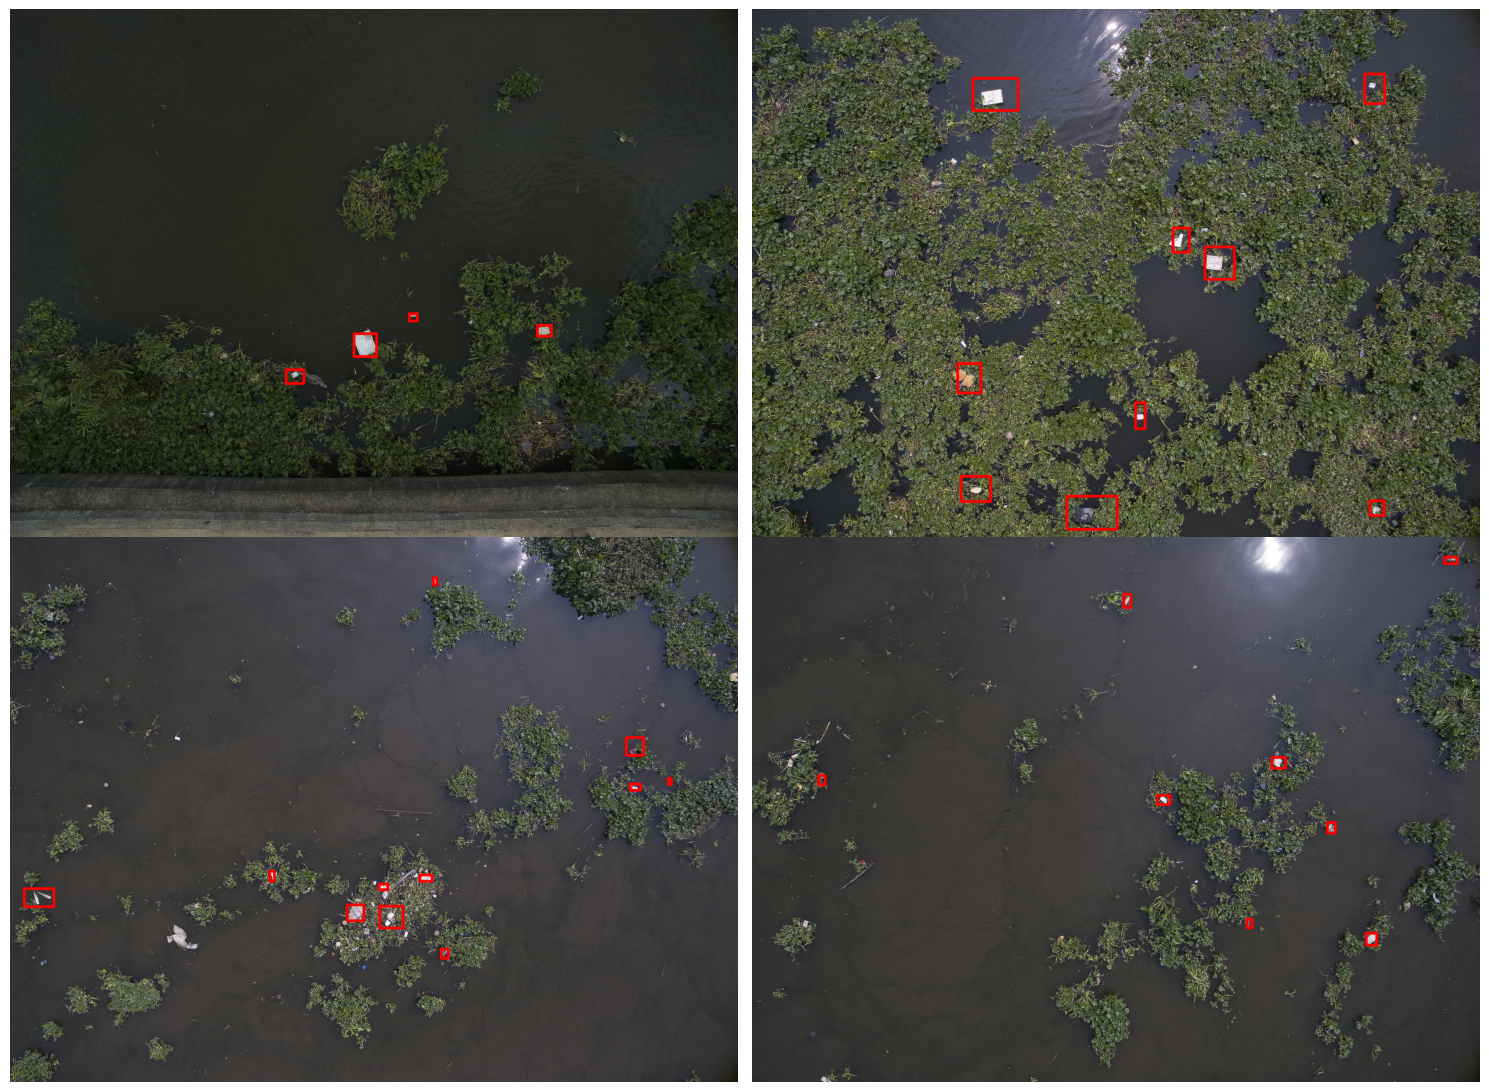

In [11]:
plot(
    image_paths='/content/drive/MyDrive/dataset-plastic/test/images',
    label_paths='/content/drive/MyDrive/dataset-plastic/test/labels',
    num_samples=4,
)

In [24]:
!yolo task=detect \
mode=predict \
model=/content/runs/detect/train/weights/best.pt \
source=/content/drive/MyDrive/dataset-plastic/test/images \
imgsz=640 \
name=yolov8n \
hide_labels=True

WARNING ⚠️ 'hide_labels' is deprecated and will be removed in 'ultralytics 8.2' in the future. Please use 'show_labels' instead.
Ultralytics YOLOv8.0.131 🚀 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 268 layers, 43607379 parameters, 0 gradients

image 1/30 /content/drive/MyDrive/dataset-plastic/test/images/DJI_0310.jpg: 480x640 5 Plastics, 80.4ms
image 2/30 /content/drive/MyDrive/dataset-plastic/test/images/DJI_0314.jpg: 480x640 6 Plastics, 51.3ms
image 3/30 /content/drive/MyDrive/dataset-plastic/test/images/DJI_0317.jpg: 480x640 5 Plastics, 51.2ms
image 4/30 /content/drive/MyDrive/dataset-plastic/test/images/DJI_0346.jpg: 480x640 2 Plastics, 51.3ms
image 5/30 /content/drive/MyDrive/dataset-plastic/test/images/DJI_0347.jpg: 480x640 1 Plastic, 51.2ms
image 6/30 /content/drive/MyDrive/dataset-plastic/test/images/DJI_0348.jpg: 480x640 3 Plastics, 51.2ms
image 7/30 /content/drive/MyDrive/dataset-plastic/test/images/DJI_0349.jpg: 480x640 5 Plastics, 5

In [44]:
def visualize(result_dir, num_samples=4):
    """
    Function accepts a list of images and plots
    them in a 2x2 grid.
    """
    plt.figure(figsize=(20, 12))
    image_names = glob.glob(os.path.join(result_dir, '*.jpg'))
    random.shuffle(image_names)
    for i, image_name in enumerate(image_names):
        image = plt.imread(image_name)
        plt.subplot(2, 2, i+1)
        plt.imshow(image)
        plt.axis('off')
        if i == num_samples-1:
            break
    plt.tight_layout()
    plt.show()

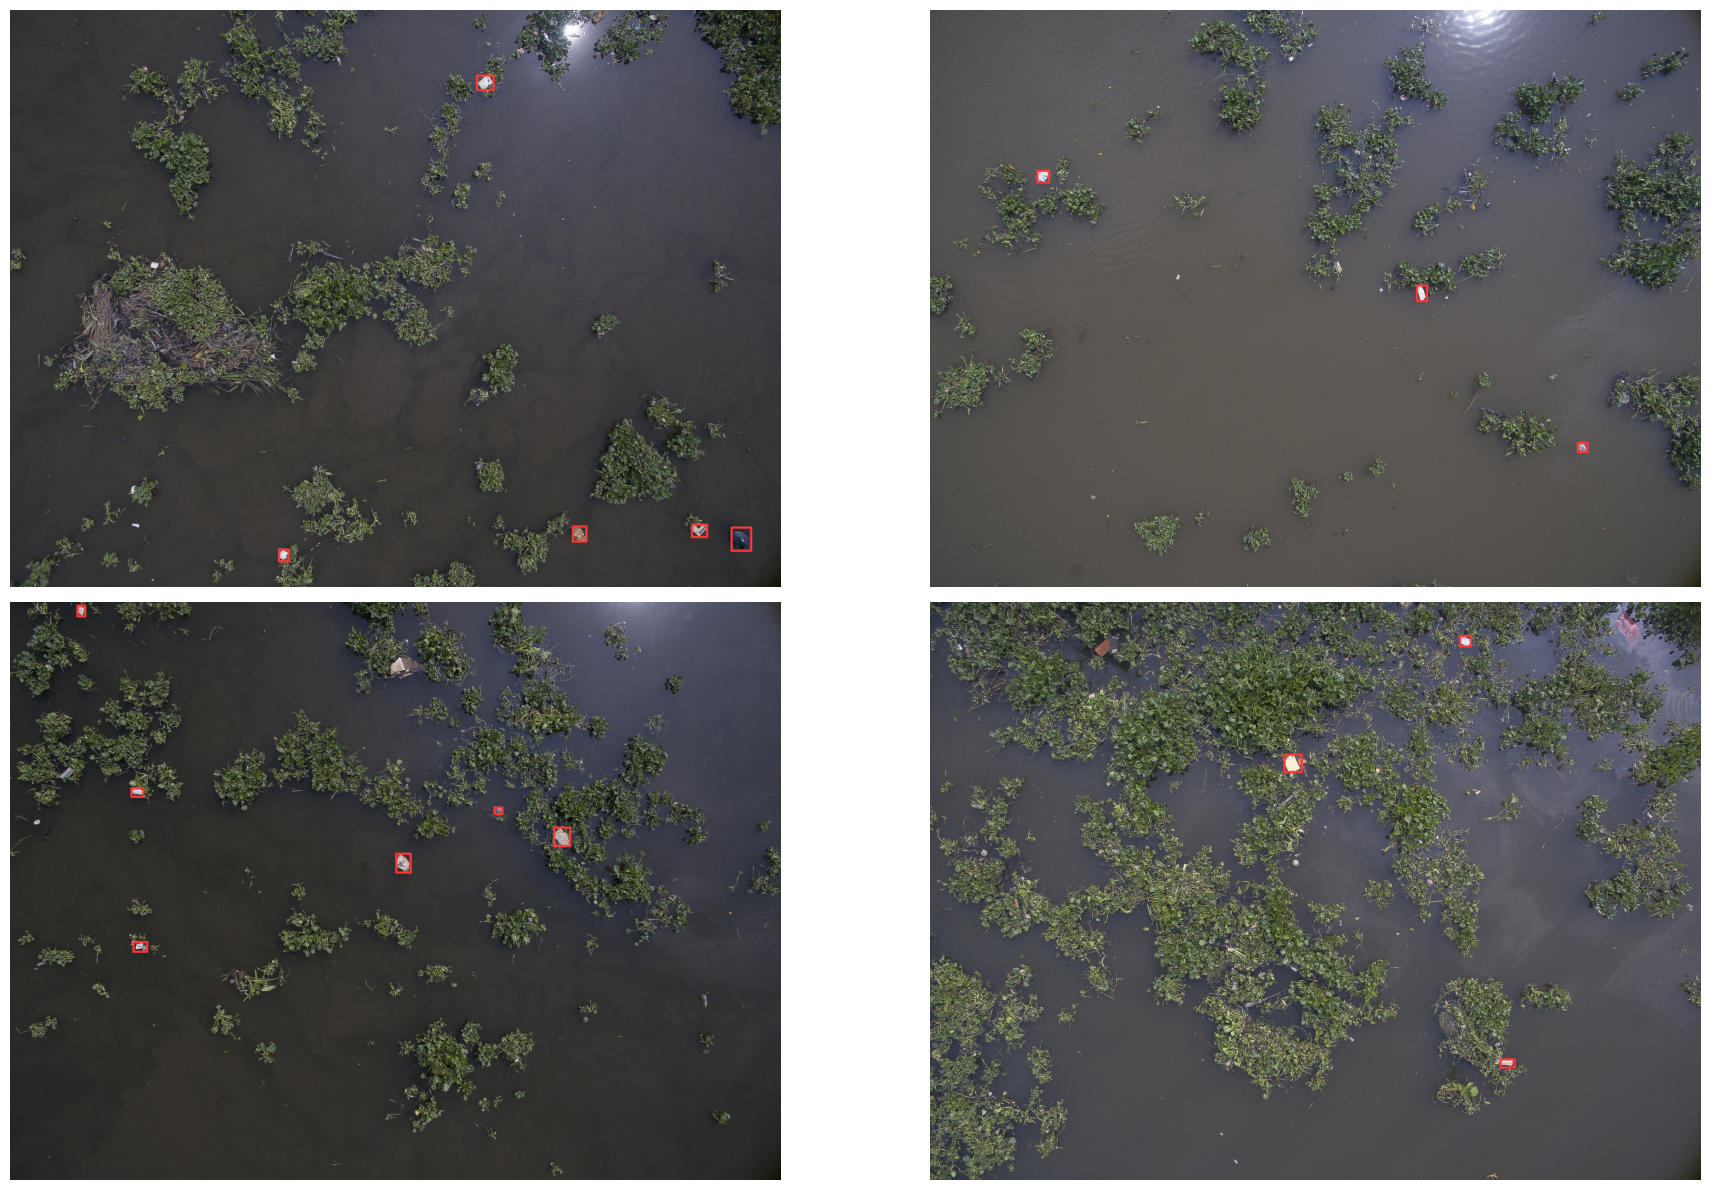

In [45]:
visualize('runs/detect/yolov8n')